#CNN Project: Medical Image Analysis for Tumor Detection


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#Data Preprocessing

In [ ]:
!pip install opencv-python
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

train_dir = '/content/Training'
test_dir = '/content/Testing'
img_size = 224

def preprocess_image(image):
    image = cv2. resize(image, (img_size, img_size))
    image = image.astype('float32') / 255.0
    return image

def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
               image = preprocess_image(image)
               images.append(image)
               labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')

Training data shape: (5712, 224, 224, 3)
Testing data shape: (1311, 224, 224, 3)


#Data Augmentation

In [ ]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to the training set
datagen.fit(X_train)

#Model Building

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False #Freeze the base model

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


#Model Training

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming 'y_train' and 'y_test' are your string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use the encoded labels in model.fit
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32),
                    validation_data=(X_test, y_test_encoded),
                    epochs=10)

Epoch 1/10
179/179 [==============================] - 118s 590ms/step - loss: -4166.0156 - accuracy: 0.2346 - val_loss: -12226.3408 - val_accuracy: 0.2334
Epoch 2/10
179/179 [==============================] - 89s 495ms/step - loss: -29044.4238 - accuracy: 0.2344 - val_loss: -49882.3477 - val_accuracy: 0.2334
Epoch 3/10
179/179 [==============================] - 89s 498ms/step - loss: -81415.6562 - accuracy: 0.2344 - val_loss: -114237.2188 - val_accuracy: 0.2334
Epoch 4/10
179/179 [==============================] - 84s 471ms/step - loss: -158823.3594 - accuracy: 0.2344 - val_loss: -202598.3906 - val_accuracy: 0.2334
Epoch 5/10
179/179 [==============================] - 86s 478ms/step - loss: -260480.5312 - accuracy: 0.2344 - val_loss: -314285.2812 - val_accuracy: 0.2334
Epoch 6/10
179/179 [==============================] - 88s 490ms/step - loss: -382543.3750 - accuracy: 0.2344 - val_loss: -446984.7812 - val_accuracy: 0.2334
Epoch 7/10
179/179 [==============================] - 87s 484ms

#Model Evaluation

41/41 [==============================] - 5s 127ms/step - loss: -1169807.0000 - accuracy: 0.2334
Test accuracy: 23.34%
41/41 [==============================] - 5s 124ms/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.23      1.00      0.38       306
     notumor       0.00      0.00      0.00       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.23      1311
   macro avg       0.06      0.25      0.09      1311
weighted avg       0.05      0.23      0.09      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


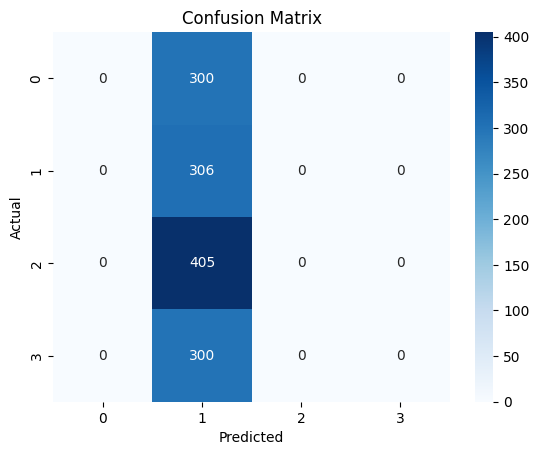

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming 'y_train' and 'y_test' are your string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encode training labels
y_test_encoded = label_encoder.transform(y_test)  # Encode test labels

#Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test accuracy: {accuracy*100:.2f}%')

#Classification Report
from sklearn.metrics import classification_report
y_pred = (model.predict(X_test)>0.5).astype("int32")

# Decode predicted labels to match the string format of y_test
y_pred_decoded = label_encoder.inverse_transform(y_pred.flatten())
print(classification_report(y_test, y_pred_decoded))

#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_decoded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()